In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import math
import time
import numpy as np
import scipy
from scipy import ndimage
import ghalton
import dicom
from scipy.interpolate import interp1d

In [3]:
'''
Helper function that cleans up list_directory
removes hidden files
'''
def clean(lis):
    try:
         
        lis.remove('.DS_Store')
    except:
        lis = lis
    return lis

'''
Helper function that retrieves all data files
cleans up the directory to leave only .dat files
'''
def get_files(lis):
    try:
        for i in list(lis):
            if('.dat' not in i):
                lis.remove(i)
    except:
        lis = lis
    return lis

#One Pineapple with 5 degrees rotation#

In [4]:
path = '/Users/zyzdiana/Dropbox/Spring2015/AC297r/Pineapple_images/'
files = get_files(os.listdir(path))
print files

['Pos_1_Vol_1.dat', 'Pos_1_Vol_2.dat', 'Pos_1_Vol_3.dat', 'Pos_1_Vol_4.dat', 'Pos_1_Vol_5.dat', 'Pos_2_Vol_1.dat', 'Pos_2_Vol_2.dat', 'Pos_2_Vol_3.dat', 'Pos_2_Vol_4.dat', 'Pos_2_Vol_5.dat']


**First, visulize the volumes at the two positions**

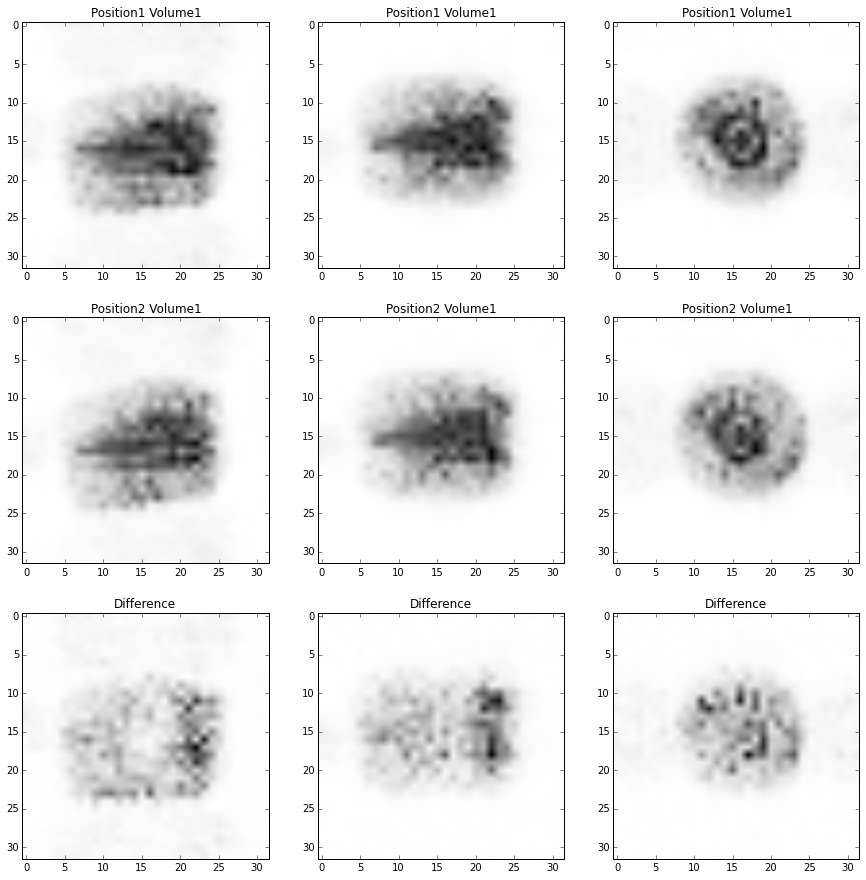

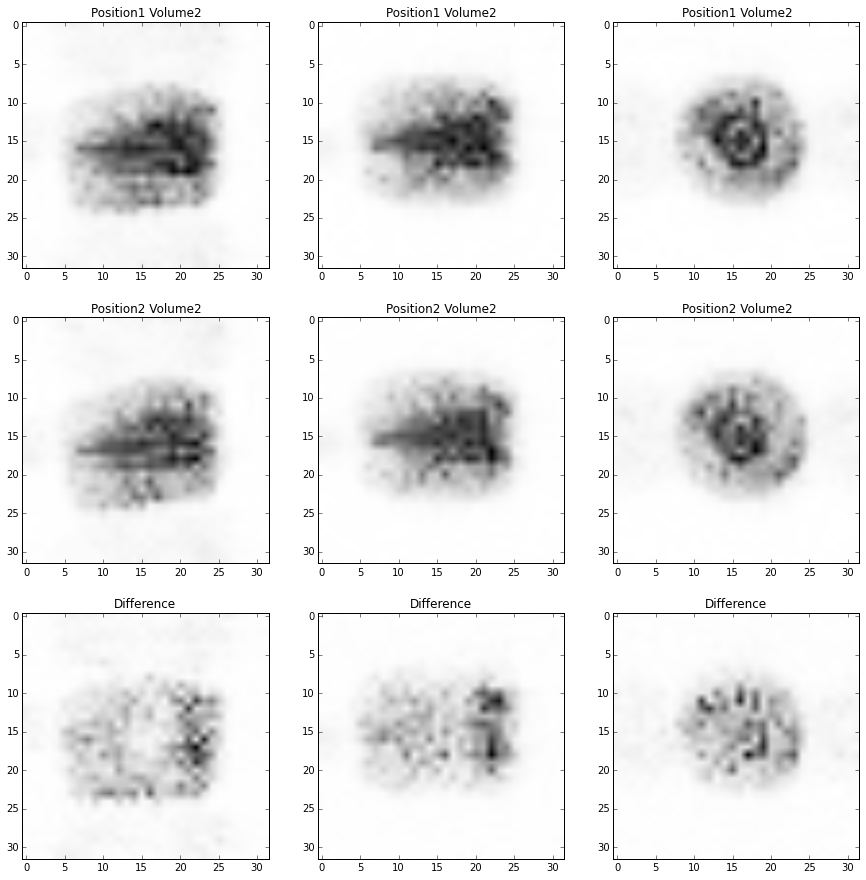

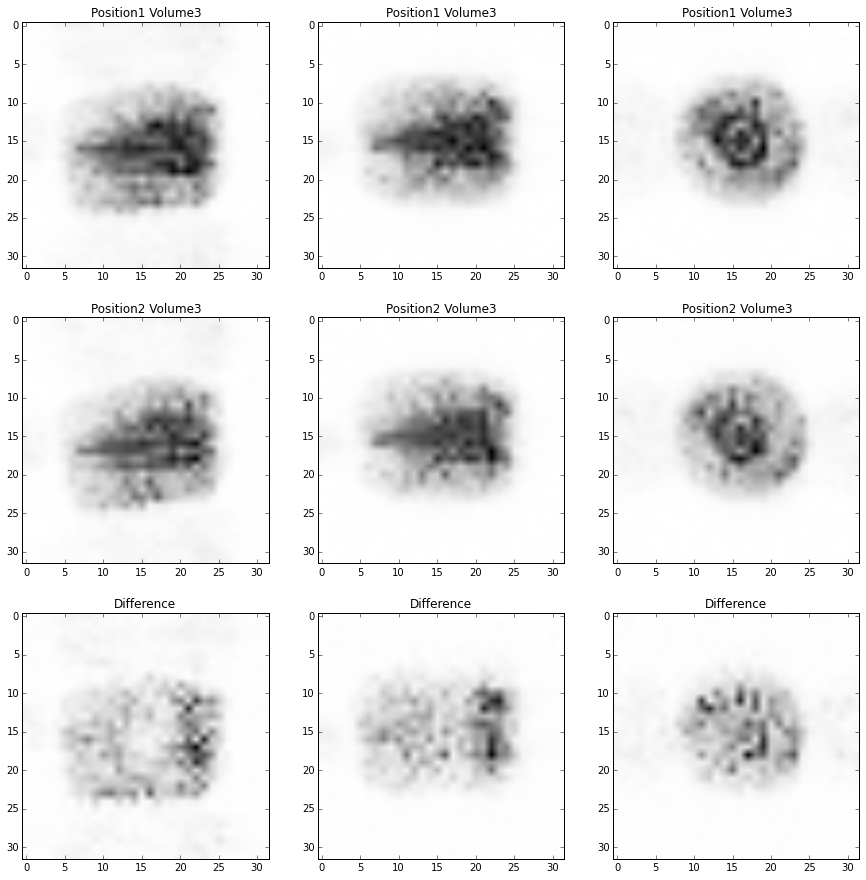

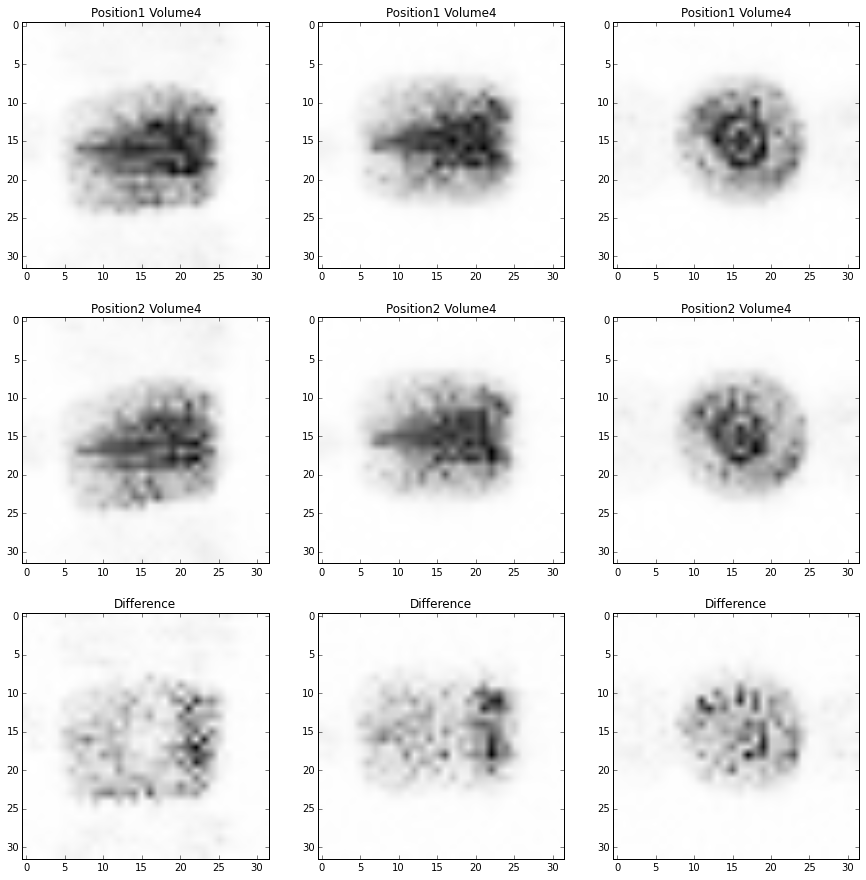

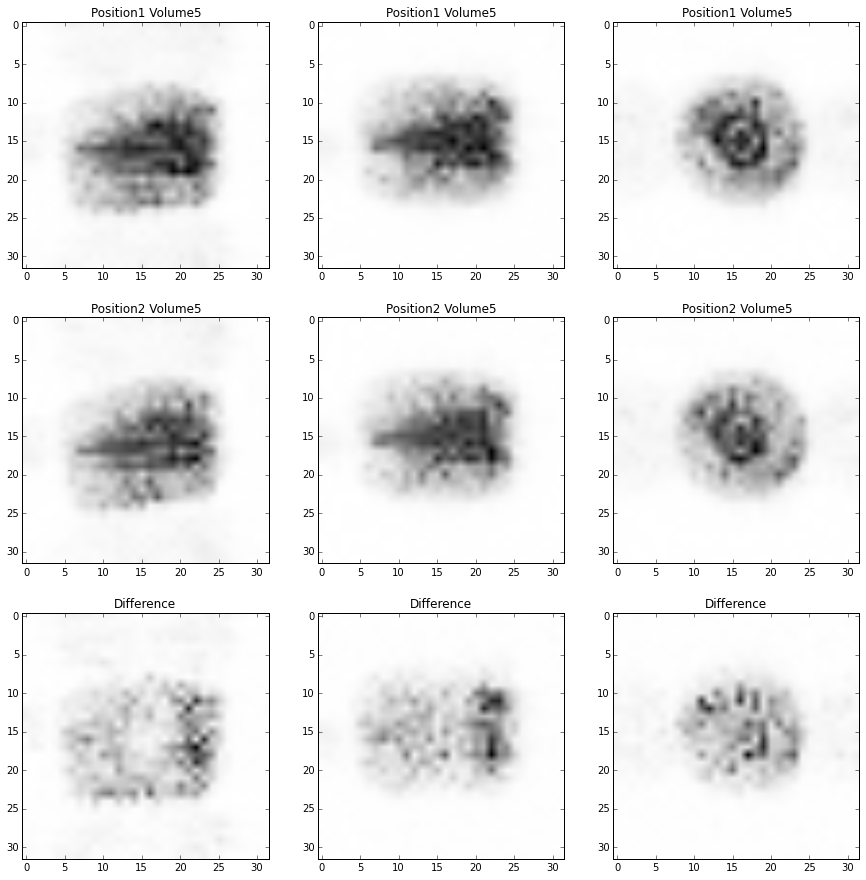

In [5]:
length = len(files)/2
for l in xrange(length):
    vol1 = np.array(np.memmap(path+files[l], dtype=np.float32, mode='r',shape=(32,32,32)))
    vol2 = np.array(np.memmap(path+files[l+5], dtype=np.float32, mode='r',shape=(32,32,32)))
    diff = vol1-vol2
    fig, ax = plt.subplots(3,3)
    fig.set_figwidth(15)
    fig.set_figheight(15)
    [ax[0][i].imshow(vol1.max(axis=i),cmap='Greys') for i in xrange(3)]
    [ax[0][i].set_title('Position1 Volume%s' % (l+1)) for i in xrange(3)]
    [ax[1][i].imshow(vol2.max(axis=i),cmap='Greys') for i in xrange(3)]
    [ax[1][i].set_title('Position2 Volume%s' % (l+1)) for i in xrange(3)]
    [ax[2][i].imshow(diff.max(axis=i),cmap='Greys') for i in xrange(3)]
    [ax[2][i].set_title('Difference') for i in xrange(3)]
    plt.show()
    plt.close(fig)

##Bilinear Interpolation##

We need to find unknown pixel value at the new point $(x,y)$, and we know the pixel values at points 
$Q_{11} = (x_1,y_1), Q_{12} = (x_1, y_2), Q_{22} = (x_2, y_2), Q_{21} = (x_2, y_1).$ To do bilinear interpolation, we need to perform linear interpolation along the x-axis and y-axis. First we use the four know points to do linear interpolation along the x-axis, and we need to define two helper points  $R_1 = (x,y_1)$, and $R_2 = (x,y_2)$. We have

$$f(R_1) = \frac{x_2-x}{x_2-x_1} f(Q_{11}) + \frac{x-x_1}{x_2-x_1} f(Q_{21}) $$

$$f(R_2) = \frac{x_2-x}{x_2-x_1} f(Q_{12}) + \frac{x-x_1}{x_2-x_1} f(Q_{21}) $$

Now we can do linear interpolation along the y-axis with $R_1$ and $R_2$, which gives us,

$$f(P) = \frac{y_2-y}{y_2-y_1} f(R_1) + \frac{y-y_1}{y_2-y_1} f(R_2)$$

Let's denote $a = x_2-x, b = x-x_1, c=y-y_1, d=y_2-y,$ then we have the final interpolation result,

$$\begin{align}
f(P) &= \frac{ad}{(c+d)(a+b)} f(Q_{11}) + \frac{bd}{(c+d)(a+b)}f(Q_{21}) + \frac{ac}{(c+d)(a+b)} f(Q_{12}) + \frac{bc}{(c+d)(a+b)}f(Q_{22})\\
&= \frac{1}{(c+d)(a+b)}(ad\cdot f(Q_{11})+bd\cdot f(Q_{21})+ac\cdot f(Q_{12})+bc\cdot f(Q_{22}))
\end{align}$$

In this case, the known pixels are located on integer grid, so $a+b=c+d=1$, and that gives,

$$f(P) = ad\cdot f(Q_{11})+bd\cdot f(Q_{21})+ac\cdot f(Q_{12})+bc\cdot f(Q_{22})$$

<img src = "./bilinear2.png" height="350" width="350">

Now we can start implementing the bilinear interpolation.

<span style="color:red">
Before performing any bilinear interpolation, first check whether the given axis is already on the integer grid. If they are, then no interpolation is needed, simply return the values at the given coordinates. This solves the margin problem in the boundary cases of image rotation.
</span>

In [6]:
def bilinear_interp(image, x, y):
    
    x = np.asarray(x)
    y = np.asarray(y)

    # find the closes grid of the target points
    x1 = np.floor(x).astype(int)
    
    # Take care of boundary conditions
    # check if the input grid x, y is already on the original grid (i.e. special rotations)
    if (np.allclose(x.astype(int),x1)):
        return image[y.astype(int),x.astype(int)]
    
    x2 = x1 + 1
    y1 = np.floor(y).astype(int)
    y2 = y1 + 1
    
    
    # we need to clip the range 
    x1 = np.clip(x1, 0, image.shape[1]-1)
    x2 = np.clip(x2, 0, image.shape[1]-1)
    y1 = np.clip(y1, 0, image.shape[0]-1)
    y2 = np.clip(y2, 0, image.shape[0]-1)

    # get the four know points
    Q11 = image[y1, x1]
    Q21 = image[y1, x2]
    Q12 = image[y2, x1]
    Q22 = image[y2, x2]

    # get weights, note that here we are dealing with 1 grid, so c+d = a+b = 1
    a = x2 - x
    b = x - x1
    c = y - y1
    d = y2 - y

    return a*d*Q11 + b*d*Q21 + a*c*Q12 + b*c*Q22

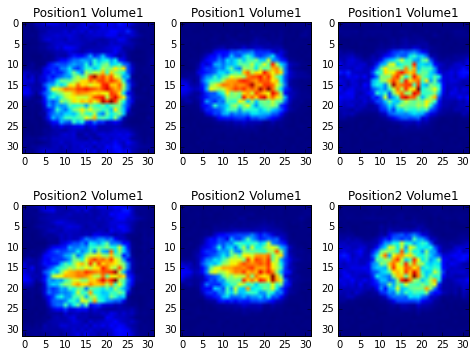

In [6]:
# Choose two volume and slice them to for testing.
vol1 = np.array(np.memmap(path+files[0], dtype=np.float32, mode='c', shape=(32,32,32)))
vol2 = np.array(np.memmap(path+files[5], dtype=np.float32, mode='c', shape=(32,32,32)))
fig, ax = plt.subplots(2,3)
fig.set_figwidth(8)
fig.set_figheight(6)
[ax[0][i].imshow(vol1.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Position1 Volume%s' % (1)) for i in xrange(3)]
[ax[1][i].imshow(vol2.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Position2 Volume%s' % (1)) for i in xrange(3)]
plt.show()
plt.close(fig)

Look at one volume slice by slice.

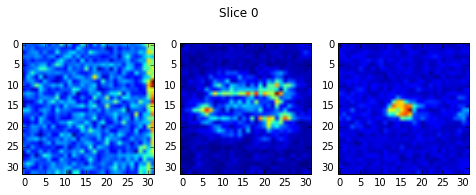

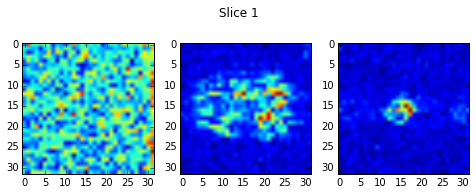

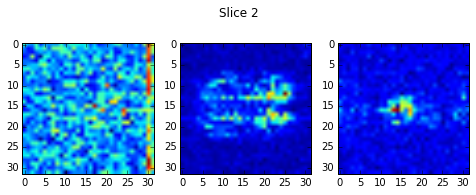

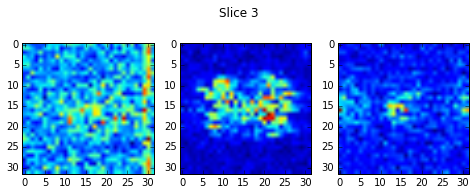

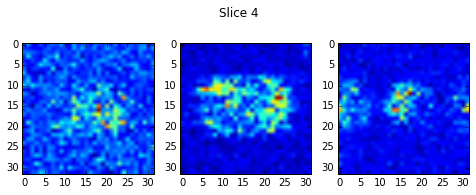

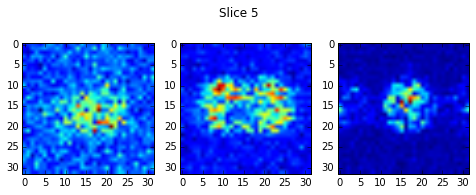

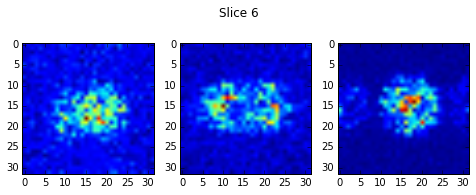

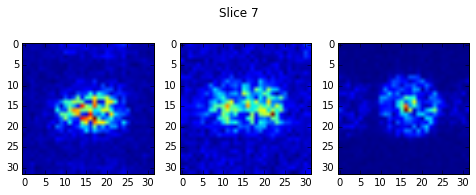

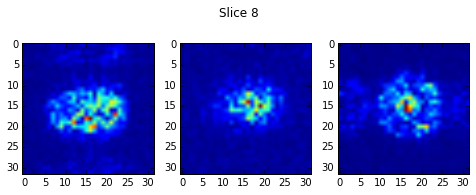

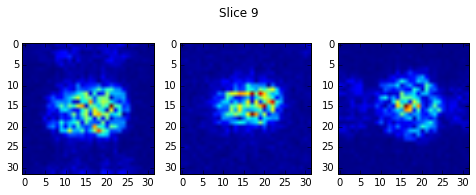

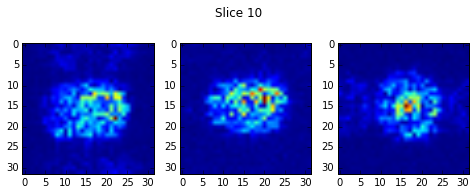

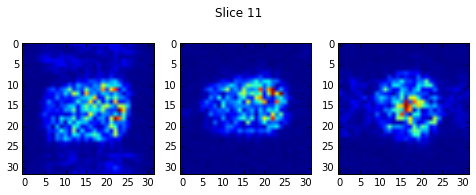

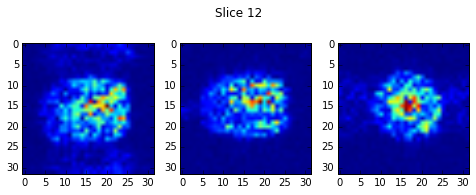

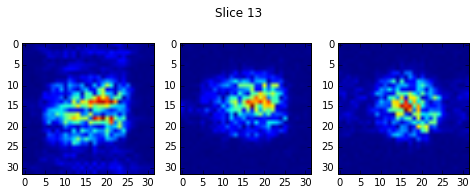

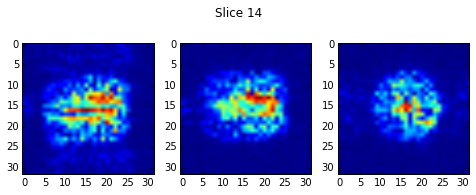

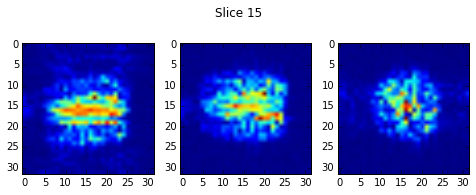

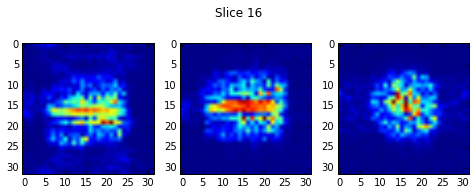

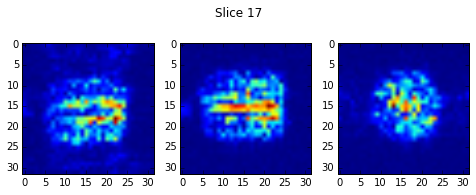

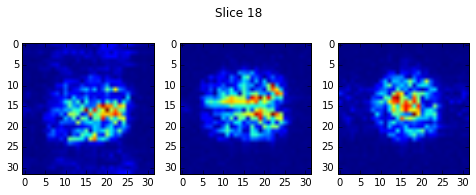

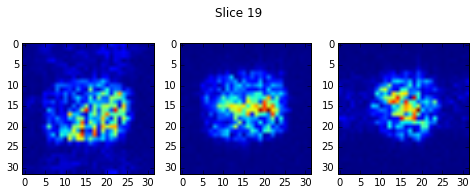

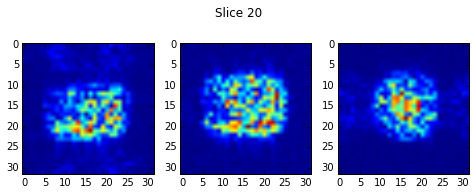

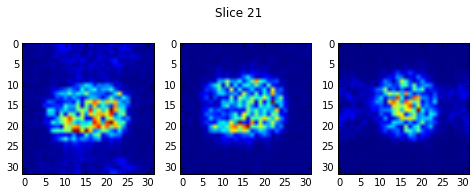

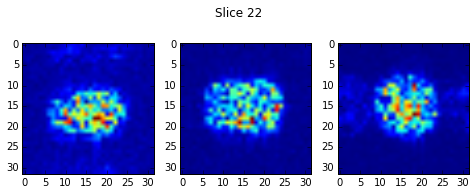

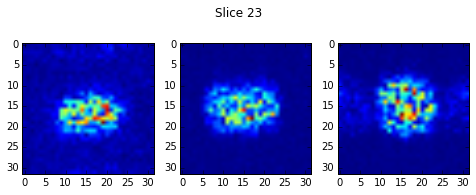

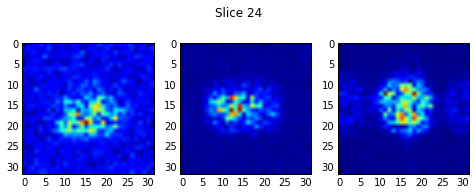

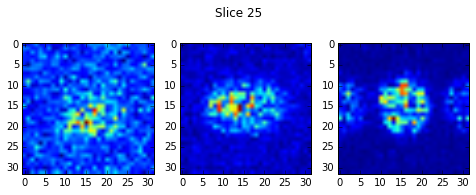

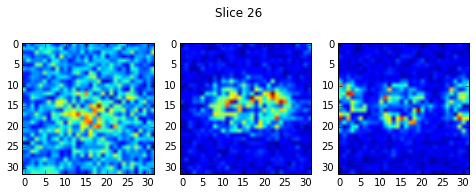

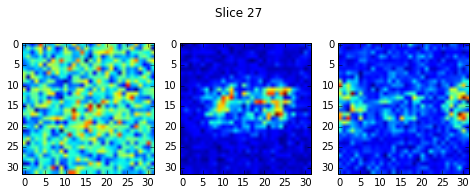

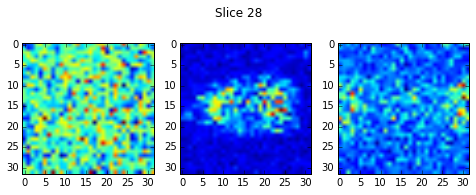

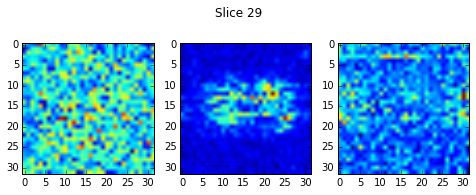

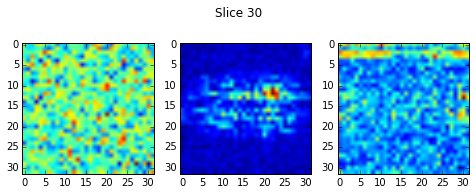

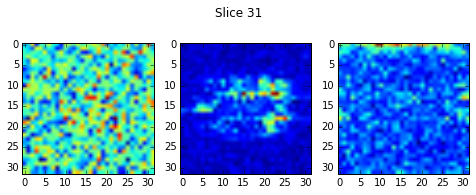

In [7]:
for i in xrange(32):
    fig, ax = plt.subplots(1,3)
    fig.set_figwidth(8)
    fig.set_figheight(3)
    fig.suptitle('Slice %s' % i, fontsize='large')
    ax[0].imshow(vol1[i,:,:])
    ax[1].imshow(vol1[:,i,:])
    ax[2].imshow(vol1[:,:,i])
    plt.show()
    plt.close(fig)

###Test Bilinear Interpolation###

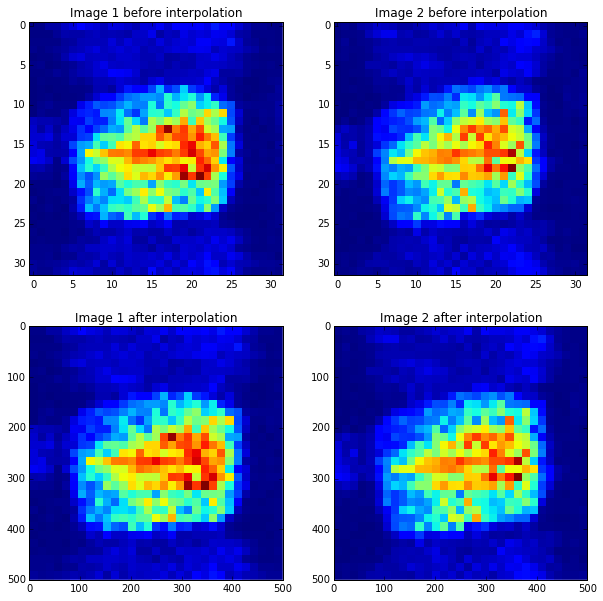

In [8]:
im1 = vol1.max(axis=0)
im2 = vol2.max(axis=0)
# create meshgrid for interpolation
grid_x, grid_y = np.meshgrid(np.linspace(0,31,500),np.linspace(0,31,500))

# interpolate im1 and im2 on the same grid
im1_bi = bilinear_interp(im1,grid_x,grid_y)
im2_bi = bilinear_interp(im2,grid_x,grid_y)
fig, ax = plt.subplots(2,2)
fig.set_figwidth(10)
fig.set_figheight(10)
ax[0][0].imshow(im1, interpolation='None')
ax[0][0].set_title("Image 1 before interpolation")
ax[1][0].imshow(im1_bi, interpolation='None')
ax[1][0].set_title("Image 1 after interpolation")
ax[0][1].imshow(im2, interpolation='None')
ax[0][1].set_title("Image 2 before interpolation")
ax[1][1].imshow(im2_bi, interpolation='None')
ax[1][1].set_title("Image 2 after interpolation")
plt.show()
plt.close(fig)

#Bicubic Interpolation#

<img src = "./cubic.png" height="400" width="400">

We have some points, a, b, c, d, and we need to estimate the value at x. Bicubic interplolation, unlike linear interpolation constructs a cubic piecewise function between a and b, and use that cubic function to estimate the unknown point x. Now that we have a cubic function, there will be four coefficients, so we neet four known points to solve the system.

$$f(x) = \sum\limits_{i=0}^{i=3}a_i x^i = a_0 + a_1x+ a_2x^2 + a_3x^3$$

Then, we compute this function at the four known points

$$
\left\{
\begin{array}{ll}
      f(c) = a_0 + a_1c+ a_2c^2 + a_3c^3 \\
      f(a) = a_0 + a_1a+ a_2a^2 + a_3a^3 \\
      f(b) = a_0 + a_1b+ a_2b^2 + a_3b^3 \\
      f(d) = a_0 + a_1d+ a_2d^2 + a_3d^3 \\
\end{array} 
\right.
$$

We can rewrite the equations into matrix form. 
$$
\begin{bmatrix}
f(c) \\
f(a) \\
f(b) \\
f(d) \\
\end{bmatrix} =
\begin{bmatrix}
1 & 1 & 1 & 1 \\
c & a & b & d \\
c^2 & a^2 & b^2 & d^2 \\
c^3 & a^3 & b^3 & d^3 \\
\end{bmatrix}
\begin{bmatrix}
a_0\\
a_1\\
a_2\\
a_3 \\
\end{bmatrix}
$$

Denote the above equation as $\boldsymbol{Y} = \boldsymbol{X}\boldsymbol{A}$, we can solve for the coefficients $\boldsymbol{A} = \boldsymbol{X}^{-1}\boldsymbol{Y}$

<img src = "./bicubic.png" height="400" width="400">

Now for 2 dimention, say that we need to estimate the value at point $(x,y) = (\frac{1}{2},\frac{1}{2})$, we need to interpolate using the values at the grid around, and the derivatives of the cubic function ${f(\cdot)}$ at these grid points. 

$$f(x,y) = \sum_{i=0}^3 \sum_{j=0}^3 a_{ij} x^i y^j$$

With $a_{ij}$ defined as follows,
$$
\begin{align*}
f(0,0) &= a_{00}\\
f(1,0) &= a_{00} + a_{10} + a_{20} + a_{30}\\
f(0,1) &= a_{00} + a_{01} + a_{02} + a_{03}\\
f(1,1) &=\sum_{i=0}^3 \sum_{j=0}^3 a_{ij}\\
\partial_xf(0,0) &= a_{10}\\
\partial_xf(1,0) &= a_{10} + 2a_{20} + 3a_{30}\\
\partial_xf(0,1) &= a_{10} + a_{11} + a_{12} + a_{13}\\
\partial_xf(1,1) &= \sum_{i=1}^3 \sum_{j=0}^3 a_{ij} i  \\
\partial_yf(0,0) &= a_{01}\\
\partial_yf(1,0) &= a_{01} + a_{11} + a_{21} + a_{31}\\
\partial_yf(0,1) &= a_{01} + 2a_{02} + 3a_{03}\\
\partial_yf(1,1) &= \sum_{i=0}^3 \sum_{j=1}^3 a_{ij} j \\
\partial_{xy}f(0,0) &= a_{11}\\
\partial_{xy}f(1,0) &= a_{11} + 2a_{21} + 3a_{31}\\
\partial_{xy}f(0,1) &= a_{11} + 2a_{12} + 3a_{13}\\
\partial_{xy}f(1,1) &= \sum_{i=1}^3 \sum_{j=1}^3 a_{ij} i j \\
\end{align*}
$$

Now we can compute the value for point (x,y),
$$
\begin{align}
f(x,y) &= \sum_{i=0}^3 \sum_{j=0}^3 a_{ij} x^{i} y^j\\
\partial_xf(x,y) &= \sum_{i=1}^3 \sum_{j=0}^3 a_{ij} i x^{i-1} y^j\\
\partial_yf(x,y) &= \sum_{i=0}^3 \sum_{j=1}^3 a_{ij} x^i j y^{j-1}\\
\partial_{xy}f(x,y) &= \sum_{i=1}^3 \sum_{j=1}^3 a_{ij} i x^{i-1} j y^{j-1}\\
\end{align}
$$

In matrix form we have,

$$
\boldsymbol{A}=\left[\begin{smallmatrix}a_{00}&a_{10}&a_{20}&a_{30}&a_{01}&a_{11}&a_{21}&a_{31}&a_{02}&a_{12}&a_{22}&a_{32}&a_{03}&a_{13}&a_{23}&a_{33}\end{smallmatrix}\right]^T\\
\boldsymbol{Y}=\left[\begin{smallmatrix}f(0,0)&f(1,0)&f(0,1)&f(1,1)&\partial_xf(0,0)&\partial_xf(1,0)&\partial_xf(0,1)&\partial_xf(1,1)&\partial_yf(0,0)&\partial_yf(1,0)&\partial_yf(0,1)&\partial_yf(1,1)&\partial_{xy}f(0,0)&\partial_{xy}f(1,0)&\partial_{xy}f(0,1)&\partial_{xy}f(1,1)\end{smallmatrix}\right]^T
$$

We have $\boldsymbol{Y} = \boldsymbol{X}\boldsymbol{A}$, we can solve for the coefficients $\boldsymbol{A} = \boldsymbol{X}^{-1}\boldsymbol{Y}$, where X is as follows,



In [9]:
X = np.zeros([16,16])
X[0][0] = 1
X[1][0:4] = 1
X[2][0:13:4] = 1
X[3] = 1
X[4][1] = 1 
X[5][1:4] = [1,2,3]
X[6][1:14:4] = 1
X[7][1:4] = [1,2,3]
X[7][5:8] = [1,2,3]
X[7][9:12] = [1,2,3]
X[7][13:16] = [1,2,3]
X[8][4] = 1
X[9][4:8] = 1
X[10][4:13:4] = [1,2,3]
X[11][4:8] = 1
X[11][8:12] = 2
X[11][12:16] = 3
X[12][5] = 1
X[13][5:8] = [1,2,3]
X[14][5:15:4] = 1
X[15][5:8] = [1,2,3]
X[15][9:12] = [2,4,6]
X[15][13:16] = [3,6,9]
print X

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  2.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.]
 [ 0.  1.  2.  3.  0.  1.  2.  3.  0.  1.  2.  3.  0.  1.  2.  3.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  2.  0.  0.  0.  3.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.  1.  1.  2.  2.  2.  2.  3.  3.  3.  3.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  2.  3.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0. 

In [10]:
X_inv = np.zeros([16,16])
X_inv[0][0] = 1
X_inv[1][4] = 1
X_inv[2][0:6] = [-3,3,0,0,-2,-1]
X_inv[3][0:6] = [2,-2,0,0,1,1]
X_inv[4][8] = 1 
X_inv[5][12] = 1
X_inv[6][8:14] = [-3,3,0,0,-2,-1]
X_inv[7][8:14] = [2,-2,0,0,1,1]
X_inv[8][0:3] = [-3,0,3]
X_inv[8][8:11] = [-2,0,-1]
X_inv[9][4:7] = [-3,0,3]
X_inv[9][12:15] = [-2,0,-1]
X_inv[10] = [9,-9,-9,9, 6,3,-6,-3,6,-6,3,-3,4,2,2,1]
X_inv[11] = [-6,6,6,-6,-3,-3,3,3,-4,4,-2,2,-2,-2,-1,-1]
X_inv[12][0:3] = [2,0,-2]
X_inv[12][8:11:2] = 1
X_inv[13][4:7] = [2,0,-2]
X_inv[13][12:15:2] = 1
X_inv[14] = [-6,6,6,-6,-4,-2,4,2,-3,3,-3,3,-2,-1,-2,-1]
X_inv[15] = [4,-4,-4,4,2,2,-2,-2,2,-2,2,-2,1,1,1,1]
print X_inv

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-3.  3.  0.  0. -2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 2. -2.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -3.  3.  0.  0. -2. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  2. -2.  0.  0.  1.  1.  0.  0.]
 [-3.  0.  3.  0.  0.  0.  0.  0. -2.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -3.  0.  3.  0.  0.  0.  0.  0. -2.  0. -1.  0.]
 [ 9. -9. -9.  9.  6.  3. -6. -3.  6. -6.  3. -3.  4.  2.  2.  1.]
 [-6.  6.  6. -6. -3. -3.  3.  3. -4.  4. -2.  2. -2. -2. -1. -1.]
 [ 2.  0. -2.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  0. -2.  0.  0.  0.  0.  0.  1.  0.  1.  0.]
 [-6.  6.  6. -6. -4. -2.  4.  2. -3.  3. -3.  3. -2. -1. -2. 

In [11]:
np.linalg.inv(X_inv).astype(int)

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 1, 2, 3, 0, 2, 4, 6, 0, 3, 6, 9]])

In [12]:
def get_target_Y(x,y):
    Y = np.zeros([len(x),16])
    Y[:,0] = 1.
    Y[:,1] = x
    Y[:,2] = x**2
    Y[:,3] = x**3
    Y[:,4] = y
    Y[:,5] = x*y
    Y[:,6] = x**2*y
    Y[:,7] = x**3*y
    Y[:,8] = y**2
    Y[:,9] = x*y**2
    Y[:,10] = x**2*y**2
    Y[:,11] = x**3*y**2
    Y[:,12] = y**3
    Y[:,13] = x*y**3
    Y[:,14] = x**2*y**3
    Y[:,15] = x**3*y**3
    return Y

In [13]:
def bicubic_interp(image, x, y):
    xr = x.ravel()
    yr = y.ravel()
    
    # find the closes grid of the target points
    x1 = np.floor(x).astype(int)
    
    # Take care of boundary conditions
    # check if the input grid x, y is already on the original grid (i.e. special rotations)
    if (len(x)==len(image)):
        if(np.allclose(x.astype(int),x1)):
            return image[y.astype(int),x.astype(int)]
    x0 = x1 - 1
    x2 = x1 + 1
    x3 = x2 + 1
    y1 = np.floor(y).astype(int)
    y0 = y1 - 1
    y2 = y1 + 1
    y3 = y2 + 1
    
    # we need to clip the range 
    x0 = np.clip(x0, 0, image.shape[1]-1)
    x1 = np.clip(x1, 0, image.shape[1]-1)
    x2 = np.clip(x2, 0, image.shape[1]-1)
    x3 = np.clip(x3, 0, image.shape[1]-1)
    y0 = np.clip(y0, 0, image.shape[0]-1)
    y1 = np.clip(y1, 0, image.shape[0]-1)
    y2 = np.clip(y2, 0, image.shape[0]-1)
    y3 = np.clip(y3, 0, image.shape[0]-1)
    
    # compute the vector of coefficients A
    # first compute vector Y from known points to solve for A
    Y = np.zeros([16,len(xr)])
    Y[0] = image[y1,x1].ravel()
    Y[1] = image[y1,x2].ravel()
    Y[2] = image[y2,x1].ravel()
    Y[3] = image[y2,x2].ravel()
    
    Y[4] = ((image[y1,x2]-image[y1,x0])/2.).ravel()
    Y[5] = ((image[y1,x3]-image[y1,x1])/2.).ravel()
    Y[6] = ((image[y2,x2]-image[y2,x0])/2.).ravel()
    Y[7] = ((image[y2,x3]-image[y2,x1])/2.).ravel()
    
    Y[8] = ((image[y2,x1]-image[y0,x1])/2.).ravel()
    Y[9] = ((image[y2,x2]-image[y0,x2])/2.).ravel()
    Y[10] = ((image[y3,x1]-image[y1,x1])/2.).ravel()
    Y[11] = ((image[y3,x2]-image[y1,x2])/2.).ravel()
    
    Y[12] = ((image[y2,x2]-image[y2,x0]-image[y1,x2]+image[y1,x0])/4.).ravel()
    Y[13] = ((image[y0,x3]-image[y0,x1]-image[y2,x3]+image[y2,x1])/4.).ravel()
    Y[14] = ((image[y3,x2]-image[y3,x0]-image[y1,x2]+image[y1,x0])/4.).ravel()
    Y[15] = ((image[y3,x3]-image[y3,x1]-image[y1,x3]+image[y1,x1])/4.).ravel()
    # Compute A
    A = np.dot(X_inv,Y)
    
    # get vector Y from points that need to be interpolated
    target_Y = get_target_Y(xr-np.floor(xr), yr-np.floor(yr))
    # compute result
    result = np.dot(target_Y,A)
    # only need the diagonal values and reshape them back to original shape
    return np.reshape(result.diagonal(),x.shape)

###Test Bicubic Interpolation###

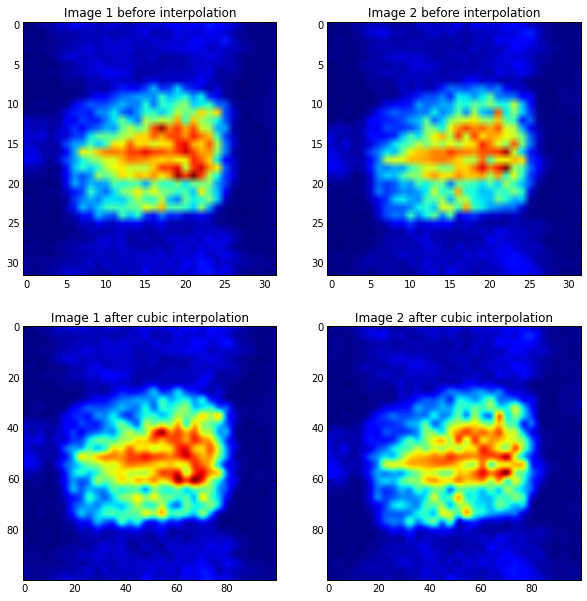

In [14]:
# create meshgrid for interpolation
grid_x, grid_y = np.meshgrid(np.linspace(0,31,100),np.linspace(0,31,100))

# interpolate im1 and im2 on the same grid
im1_cub = bicubic_interp(im1,grid_x,grid_y)
im2_cub = bicubic_interp(im2,grid_x,grid_y)
fig, ax = plt.subplots(2,2)
fig.set_figwidth(10)
fig.set_figheight(10)
ax[0][0].imshow(im1)
ax[0][0].set_title("Image 1 before interpolation")
ax[1][0].imshow(im1_cub)
ax[1][0].set_title("Image 1 after cubic interpolation")
ax[0][1].imshow(im2)
ax[0][1].set_title("Image 2 before interpolation")
ax[1][1].imshow(im2_cub)
ax[1][1].set_title("Image 2 after cubic interpolation")
plt.show()
plt.close(fig)

##Define imrotate##

The rotation matrix in 2D is as follows,

$$R(\theta) = \begin{bmatrix}
\cos \theta & -\sin \theta \\
\sin \theta & \cos \theta \\
\end{bmatrix}$$

If we need to rotate the point (x,y) by $\theta$ degrees counterclock wise, then the coordinates for the new point is 
$(\cos \theta x + \sin\theta y, \sin\theta x+\cos\theta y)$

<span style="color:red">
After checking the cosine and sine values for 90 and 180 degrees, I find that there are numerical errors in the results. Hence the grid on which the image need to be interpolated is also affected by the numerical errors. These errors are small enough in floating points, but when taking the floor or ceilling values of these errors, the errors are enlarged. Therefore, I rounded all sine and cosine computation to 15 decimals to avoid overflow or underflow.
</span>

In [15]:
def to_radian(theta):
    return theta*np.pi/180.

def rotate_coords(x, y, theta, ox, oy):
    """
    Rotate arrays of coordinates x and y by theta radians about the
    point (ox, oy).

    """
    s, c = np.sin(theta), np.cos(theta)
    # round up the sin and cos to 15 decimals
    s = np.round(s,15)
    c = np.round(c,15)
    x, y = np.asarray(x) - ox, np.asarray(y) - oy
    return x * c - y * s + ox, x * s + y * c + oy

def circle_mask(image):
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    r = image.shape[0]/2.-0.5
    y, x = np.ogrid[-ox:image.shape[0]-ox, -oy:image.shape[0]-oy]
    mask = x*x + y*y <= r*r
    image[~mask] = 0
    return image

def imrotate(image, theta, interpolation = 'bilinear', mask=False, x=None, y=None):
    theta = to_radian(theta)
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    if((x == None) and (y == None)): #i.e. x and y not specified
        x = np.linspace(0, image.shape[1]-1, image.shape[1]).astype(int)
        y = np.linspace(0, image.shape[0]-1, image.shape[0]).astype(int)
    
    xx, yy = np.meshgrid(x,y)
    
    dest_x, dest_y = rotate_coords(xx, yy, theta, ox, oy)
    
    if(interpolation == 'bicubic'):
        dest = bicubic_interp(image, dest_x, dest_y)
    if(interpolation == 'bilinear'):
        dest = bilinear_interp(image, dest_x, dest_y)

        
    if(mask):
        dest = circle_mask(dest)
    return dest

In [16]:
def bessel_rotate(image, theta):
    Ib = np.empty(image.shape)
    theta = to_radian(theta)
    
    s = (image.shape[0]-1)/2.

    x = np.linspace(-s, s, image.shape[1])
    y = np.linspace(-s, s, image.shape[0])
    
    xx, yy = np.meshgrid(x,y)
    
    rM = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

    for i in np.arange(-s,s):
        for j in np.arange(-s,s):
            x = np.dot(rM, np.array([i,j]))

            if(np.sum(abs(x)>s)):
                Ib[i+s,j+s]=0
                
            else:
                R = np.sqrt((xx-x[1])**2 + (yy-x[0])**2)
                Bess = scipy.special.jv(1, np.pi*R)/(np.pi*R)
                Bess[np.isclose(R,0)]=0.5

                Ib[i+s,j+s] = (np.sum(image*Bess))*np.pi/2
            #print Ib[i+s, j+s]
    return Ib

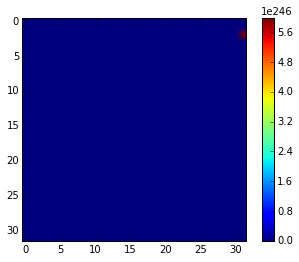

In [17]:
plt.imshow(bessel_rotate(im1,5))
plt.colorbar()
plt.show()

<span style="color:red">
After fixing inpterpolation and rotation, the boundary cases give perfect results when compared to the original image.
</span>

###Test Imrotate###

test some bounary conditions, rotation 0, 90, and 180

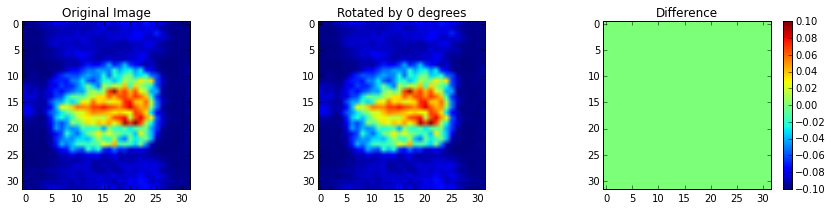

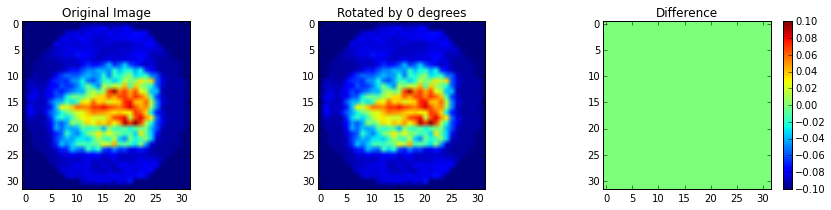

In [20]:
# rotation by 0 degrees, should return itself
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
fig.set_figheight(3)
ax[0].imshow(im1)
ax[0].set_title("Original Image")
ax[1].imshow(imrotate(im1,0))
ax[1].set_title("Rotated by 0 degrees")
ax2 = ax[2].imshow(imrotate(im1,0)-im1)
ax[2].set_title("Difference")
plt.colorbar(ax2)
plt.show()
plt.close(fig)

# with circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
fig.set_figheight(3)
im1_cp = circle_mask(im1.copy())
ax[0].imshow(im1_cp)
ax[0].set_title("Original Image")
ax[1].imshow(imrotate(im1,0,mask=True))
ax[1].set_title("Rotated by 0 degrees")
ax2 = ax[2].imshow(imrotate(im1,0,mask=True)-im1_cp)
ax[2].set_title("Difference")
plt.colorbar(ax2)
plt.show()
plt.close(fig)

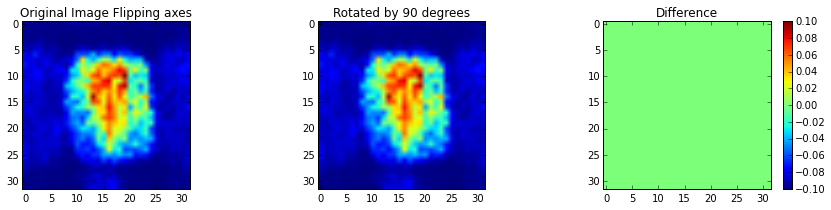

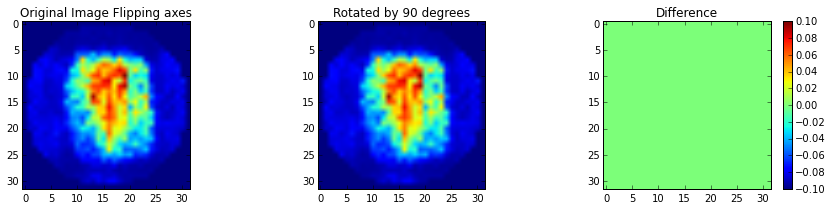

In [21]:
# rotation by 90 degrees
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
fig.set_figheight(3)
ax[0].imshow(np.flipud(im1.T))
ax[0].set_title('Original Image Flipping axes')
ax[1].imshow(imrotate(im1,90))
ax[1].set_title("Rotated by 90 degrees")
ax2 = ax[2].imshow(imrotate(im1,90)-(np.flipud(im1.T)))
ax[2].set_title("Difference")
plt.colorbar(ax2)
plt.show()
plt.close(fig)

# with circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
fig.set_figheight(3)

tmp = im1.copy()
im1_cp = circle_mask(np.flipud(tmp.T))
ax[0].imshow(im1_cp)
ax[0].set_title("Original Image Flipping axes")
ax[1].imshow(imrotate(tmp,90,mask=True))
ax[1].set_title("Rotated by 90 degrees")
ax2 = ax[2].imshow(imrotate(tmp,90,mask=True)-im1_cp)
ax[2].set_title("Difference")
plt.colorbar(ax2)
plt.show()
plt.close(fig)

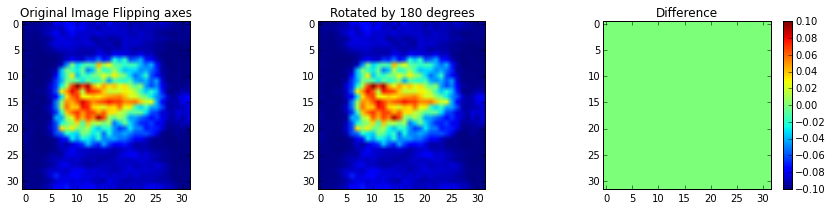

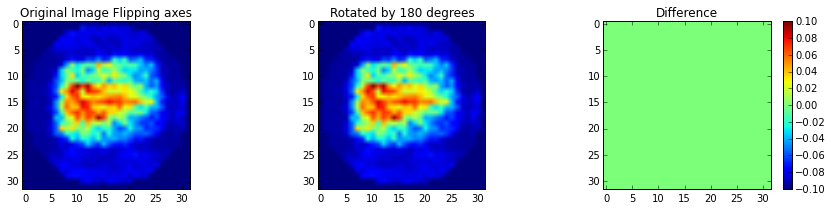

In [22]:
#rotation by 180 degrees
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
fig.set_figheight(3)
ax[0].imshow(np.flipud(np.fliplr(im1)))
ax[0].set_title('Original Image Flipping axes')
ax[1].imshow(imrotate(im1,180))
ax[1].set_title("Rotated by 180 degrees")
ax2 = ax[2].imshow(imrotate(im1,180)- (np.flipud(np.fliplr(im1))) )
ax[2].set_title("Difference")
plt.colorbar(ax2)
plt.show()
plt.close(fig)

# with circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
fig.set_figheight(3)
im1_cp = np.flipud(np.fliplr(circle_mask(im1.copy())))
ax[0].imshow(im1_cp)
ax[0].set_title("Original Image Flipping axes")
ax[1].imshow(imrotate(im1.copy(),180,mask=True))
ax[1].set_title("Rotated by 180 degrees")
ax2 = ax[2].imshow(imrotate(im1.copy(),180,mask=True)-im1_cp)
ax[2].set_title("Difference")
plt.colorbar(ax2)
plt.show()
plt.close(fig)

#Test Cost Functions:#

In [22]:
def cf_ssd(J, I):
    return np.sum((J-I)**2)
def cf_L2(J, I):
    return np.linalg.norm(J-I)
def cf_L1(J, I):
    L1 = np.reshape((J-I), [1,-1])
    return np.max(L1)

Note that in this function I'm slicing the volume in 2D, rotate each 2D image and put the back together, so the cost function results are of teh 3D volume.

In [23]:
def rot_cost_func(vol1, vol2, thetas, cf, arg, ax, interpolation = 'bilinear',mask=False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    tmp = vol1.copy()
    cost_func = np.zeros(len(thetas))
    for idx, t in enumerate(thetas):
        new_vol2 = np.ones(vol2.shape)
        for i in xrange(32):
            if(mask):
                tmp[i,:,:] = circle_mask(tmp[i,:,:])
            sub = vol2[i,:,:]
            rot = imrotate(sub, t, interpolation, mask)
            new_vol2[i,:,:] = rot
        cost_func[idx] = cf(new_vol2,tmp)
    angMin = thetas[np.argmin(cost_func)]
    ax.plot(thetas,cost_func,label='Min angle = %s' % (angMin))
    ax.set_title('%s Cost function with %s interpolation' % (arg,interpolation), fontsize=14)
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Cost function')
    ax.legend(loc=4)

In [24]:
def rot_vol(vol1, vol2, thetas):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    '''
    tmp = vol1.copy()
    for idx, t in enumerate(thetas):
        new_vol2 = np.ones(vol2.shape)
        for i in xrange(32):
            if(mask):
                tmp[i,:,:] = circle_mask(tmp[i,:,:])
            sub = vol2[i,:,:]
            rot = imrotate(sub, t, interpolation, mask)
            new_vol2[i,:,:] = rot
    return tmp, new_vol2

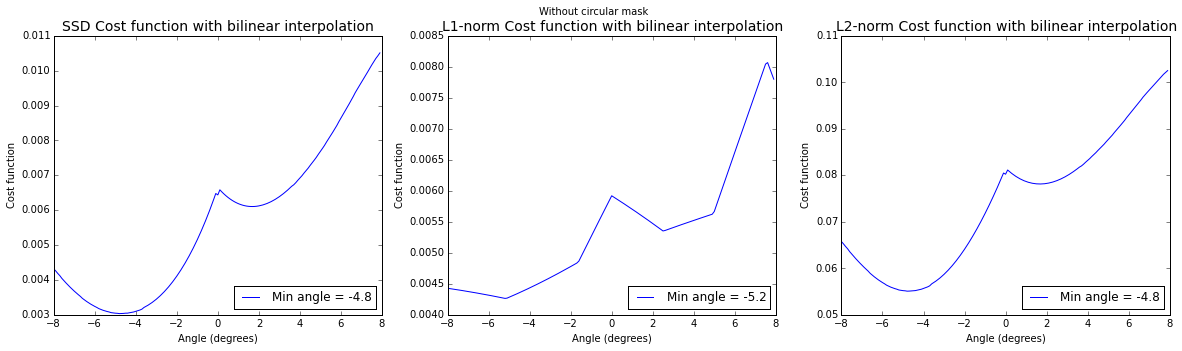

In [25]:
# Cost Function from Bilinear Interpolation
thetas=np.arange(-8,8,0.1)
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0])
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1])
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2])
plt.show()
plt.close(fig)

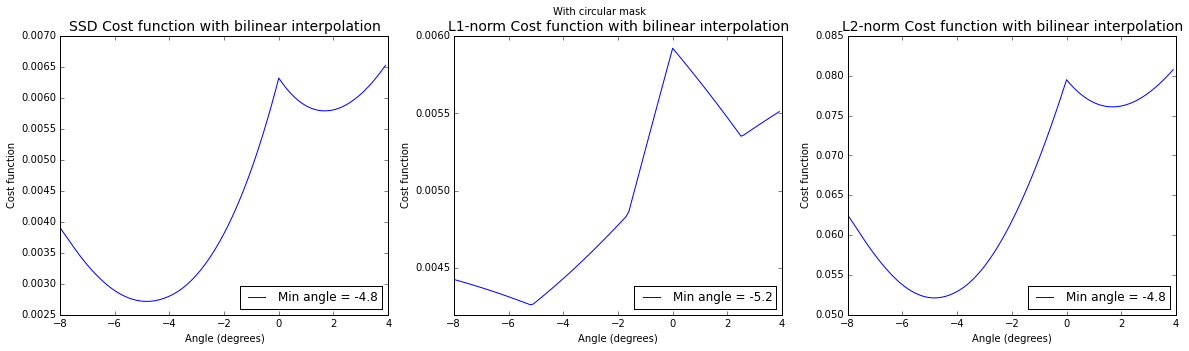

In [26]:
# Cost Function from Bilinear Interpolation
# with circular mask
thetas=np.arange(-8,4,0.1)
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("With circular mask")
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0],mask=True)
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1],mask=True)
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2],mask=True)
plt.show()
plt.close(fig)

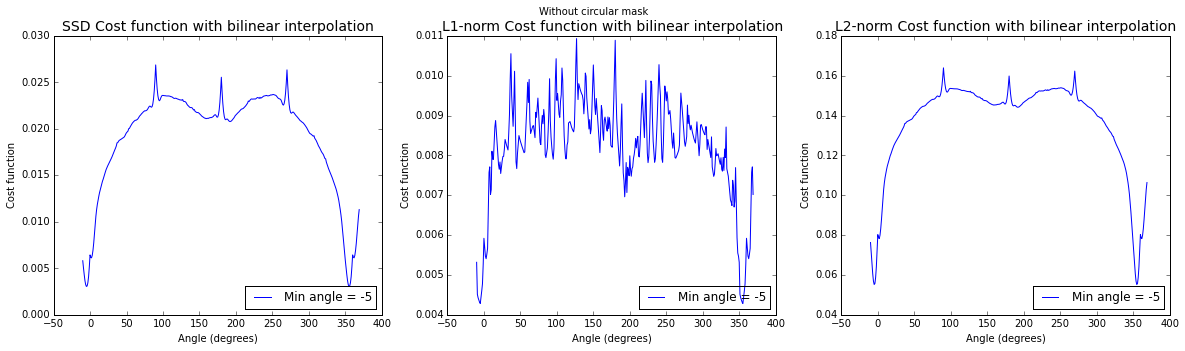

In [27]:
# Cost Function from Bilinear Interpolation for a wider range
# without mask
vol1 = np.array(np.memmap(path+files[0], dtype=np.float32, mode='c', shape=(32,32,32)))
vol2 = np.array(np.memmap(path+files[5], dtype=np.float32, mode='c', shape=(32,32,32)))

thetas=np.arange(-10,370,1)
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0])
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1])
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2])
plt.show()
plt.close(fig)

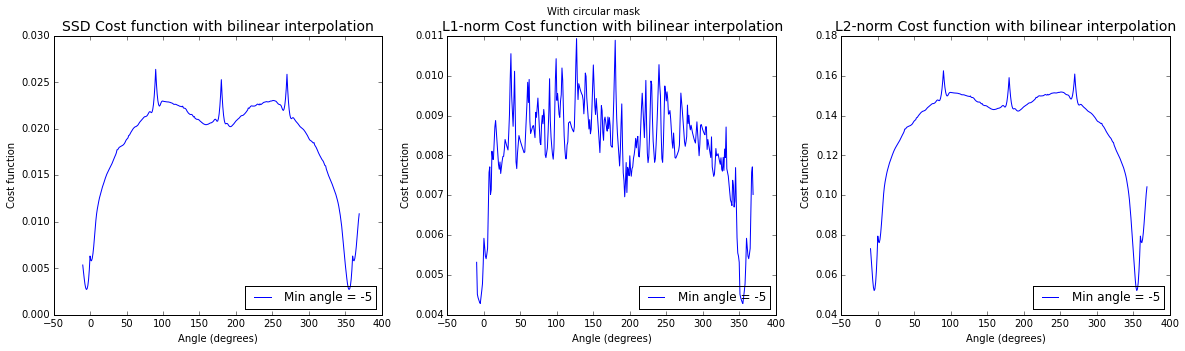

In [28]:
# Cost Function from Bilinear Interpolation for a wider range
# with mask
thetas=np.arange(-10,370,1)
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("With circular mask")
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0],mask=True)
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1],mask=True)
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2],mask=True)
plt.show()
plt.close(fig)

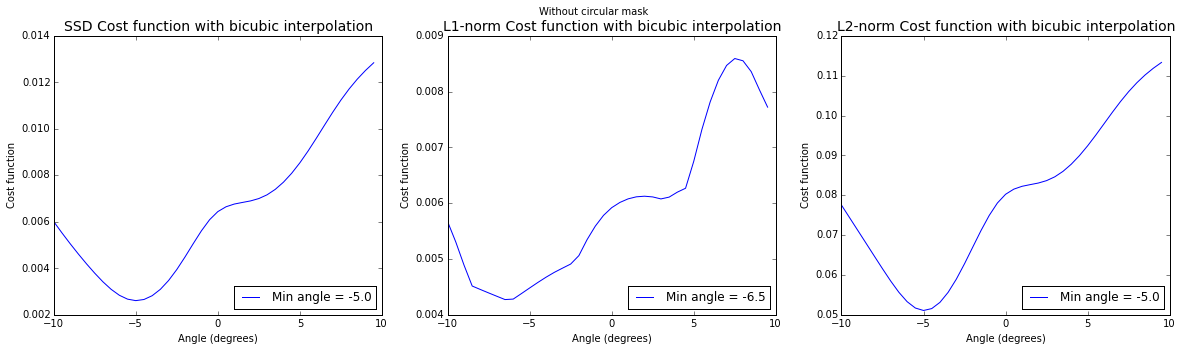

In [ ]:
# Cost function from Bicubic Interpolation
thetas=np.arange(-10,10,0.5)
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0], 'bicubic')
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1], 'bicubic')
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2], 'bicubic')
plt.show()
plt.close(fig)

In [ ]:
# Cost function from Bicubic Interpolation with wide range
thetas=np.arange(-10,370,5)
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0], 'bicubic')
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1], 'bicubic')
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2], 'bicubic')
plt.show()
plt.close(fig)

convolution

In [ ]:
# Cost function from Bicubic Interpolation
# with circular mask
thetas=np.arange(-10,10,0.5)
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("With circular mask")
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0], 'bicubic')
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1], 'bicubic')
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2], 'bicubic')
plt.show()
plt.close(fig)

## Use Halton Sampling to Evaluate Cost Function ##

In [ ]:
def halton_cost_func(N, vol1, vol2, thetas, interpolation = 'bilinear', mask = False):
    '''
    N: Number of Halton Sampling Points
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    arg: string for plot titles
    '''
    for idx, t in enumerate(thetas):
        new_vol2 = np.ones(vol2.shape)
        for i in xrange(32):
            if(mask):
                vol1[i,:,:] = circle_mask(vol1[i,:,:])
            sub = vol2[i,:,:]
            rot = imrotate(sub, t, interpolation, mask)
            new_vol2[i,:,:] = rot

    cost_func = np.zeros(len(thetas))
    t0 = time.time()
    # generate Halton Sequence in the 32*32*32 grid
    sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:2])
    sequencer.reset()
    points = sequencer.get(N)
    pts = np.array(points)
    x1 = 31 * pts[:,0]
    y1 = 31 * pts[:,1]
    
    for idx, th in enumerate(thetas):
        v2 = bicubic_interp(new_vol2.max(axis=0), x1, y1)
        v1 = bicubic_interp(vol1.max(axis=0), x1, y1)
        cost_func[idx] = cf_ssd(v2,v1)
    t1 = time.time()
    print 'Time for %s halton samples is %s seconds' % (N,t1-t0) 

    angMin = thetas[np.argmin(cost_func)]
    plt.plot(thetas,cost_func,label='Min angle = %s' % (angMin))
    plt.title('Integral SSD (%s Halton Samples) with %s interpolation\n' % (N, interpolation), fontsize=12)
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Integral SSD')
    plt.legend()
    plt.show()

##Run Cost Function on all data in the first dataset##

In [ ]:
length = len(files)/2
thetas=np.arange(-8,0,0.1)
for l in xrange(length):
    vol1 = np.memmap(path+files[l], dtype=np.float32, shape=(32,32,32))
    vol2 = np.memmap(path+files[l+5], dtype=np.float32, shape=(32,32,32))
    fig, ax = plt.subplots(1,3)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    fig.suptitle("Position 1 vs Position 2  in Volume %s\n\n" % (l+1), fontsize=16)
    rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0])
    rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1])
    rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2])
    plt.show()
    plt.close(fig)

##Summary of Results:##

It seems that SSD and L2-norm are giving consistent results across the volumes, but L1-norm is not.

In [ ]:
rot_interp

#Test Data with 12 Coils#

In [ ]:
path1 = '/Users/zyzdiana/Dropbox/vNav_Test_Data/Mar_18_Test_Data/'
files1 = get_files(os.listdir(path1))
pos1 = files1[:len(files1)/2]
pos2 = files1[len(files1)/2:]
print pos1
print pos2

In [ ]:
vol1_body = np.array(np.memmap(path1+pos1[0], dtype=np.complex64, shape=(32,32,32)))
vol2_body = np.array(np.memmap(path1+pos2[0], dtype=np.complex64, shape=(32,32,32)))

vol1_head = np.array(np.memmap(path1+pos1[5], dtype=np.complex64, shape=(12,32,32,32)))
vol2_head = np.array(np.memmap(path1+pos2[5], dtype=np.complex64, shape=(12,32,32,32)))

In [ ]:
norm_head = np.zeros([32,32,32])
for i in range(len(vol1_head)):
    norm_head += np.abs(vol1_head[i])**2 

sum up the squares of magnitudes, otherwise their would be 

In [ ]:
fig, ax = plt.subplots(2,3)
fig.set_figwidth(10)
fig.set_figheight(6)
[ax[0][i].imshow(np.abs(vol1_body).max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Position1 Body Coil Rep 1') for i in xrange(3)]
[ax[1][i].imshow(norm_head.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Position1 Head Coil Rep 1') for i in xrange(3)]
plt.show()
plt.close(fig)

In [ ]:
fig, ax = plt.subplots(12,3)
fig.set_figwidth(10)
fig.set_figheight(12*3)
for j in range(12):
    [ax[j][i].imshow(np.abs(vol1_head[j]).max(axis=i)) for i in xrange(3)]
    [ax[j][i].set_title('Position1 Head Coil %s' % (j)) for i in xrange(3)]
plt.show()
plt.close(fig)

#Read DICOM Images#

In [ ]:
PathDicom = '/Users/zyzdiana/Dropbox/vNav_Test_Data/Mar_18_Test_Data/high_res/'
filenames = clean(os.listdir(PathDicom))
lstFilesDCM = []

for f in filenames:
    lstFilesDCM.append(os.path.join(PathDicom,f))
print len(lstFilesDCM)

In [ ]:
def plot_dicom(dicom_file, ax):
    # Get ref file
    RefDs = dicom.read_file(dicom_file)

    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

    # Load spacing values (in mm)
    ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

    #arrange axis
    x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
    y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
    z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

    # The array is sized based on 'ConstPixelDims'
    ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

    # loop through all the DICOM files
    for filenameDCM in lstFilesDCM:
        # read the file
        ds = dicom.read_file(filenameDCM)
        # store the raw image data
        ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array 

    # Display the DICOM
    ax.pcolormesh(x, y, np.flipud(ArrayDicom[:, :, 80]))